# BASIC CONFIGURATIONS

In [ ]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

{'name': 'ScopeData0'}
{'name': 'ScopeData1'}
{'name': 'ScopeData2'}
{'name': 'ScopeData3'}
Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 23:58:17
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_ASIC_u1_PLLBypass.yml
Loading /u1/lorenzor/epix-hr-m-320k/software/noteboo

In [6]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [7]:
#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [8]:
#get locked lanes
time.sleep(3)
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xffffff


In [9]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [10]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()

descramble error
rawData length 48
descramble error
rawData length 28464
descramble error
rawData length 21984
descramble error
rawData length 28440


In [11]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 1 frames
Checkpoint: DataReceiver 1 has 1 frames
Checkpoint: DataReceiver 2 has 1 frames
Checkpoint: DataReceiver 3 has 1 frames


# Here we select which ASIC we want to test

In [12]:
# Change these 3 lines when you want to select another ASIC
AsicNum = 2
dataDebug = DEBUG2
ASIC = ASIC2

# From here it's all the same
root.enableAllAsics(False)
root.enableAsic(AsicNum, True)
root.enableDataRcv(False)

dataDebug.enableDataDebug(True) ##### -- This was changed !!!
dataDebug.cleanData() ##### -- This was changed !!!

# Control waveform delays - we only care about SRO here

In [16]:
%run dataProcFunctions.ipynb     #this is were my function was stored

In [17]:
# Steps = clock period of 168Mhz (5.95ns)
# Acq1 is 20us
# R0 after Acq1
# R0 Width set to 1.920uS
# SR0 needs to be launched after R0 delay + R0 width + alpha

# ------------------- 1 us integration time
AcqWidth = 160
AcqDelay = 260
setAcq1(AcqWidth, AcqDelay)

R0Width = 3425
R0Delay = 100
setR0(R0Width, R0Delay)

SR0Width = 38000
SR0Delay = R0Width + R0Delay + 10
setSR0(SR0Width, SR0Delay)


Acq1 Width set to 1.024uS
Acq1 Delay set to 1.664uS
R0 Width set to 21.920uS
R0 Delay set to 0.640uS
SR0 Width set to 226.190uS
SR0 Delay set to 21.042uS


# ADC configuration

In [18]:
# ADC settings
# ASIC.DHg.set(False)    # Set High gain
# ASIC.S2D_1_b.set(0)   # Set bias current to max (min value)
# ASIC.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
# ASIC.RefGenB.set(2)   # Don't touch

setBestSettings(REGCTRL,ASIC)

ASIC.mTest.set(True)      # Don't touch
print(ASIC.mTest.get())   # Don't touch

#write to DAC
DAC.FastDac.DacValue.set(0x45fff)
DAC.FastDac.DacValue.set(0x5ffff)
print("Fast DAC set to {}V".format(DAC.FastDac.DacValueV.get()))

R0 Width set to 7.808uS
R0 Delay set to 1.280uS
Acq1 Width set to 3.584uS
Acq1 Delay set to 4.864uS
-------------------------
Baseline time:    3.5839999999999996 uS
Integration time: 3.584 uS
Sampling done at: 8.448 uS
-------------------------
ASIC configured
True
Fast DAC set to 0.937V


# Check that average ADU output is close to midrange 16384
This is the worst-case scenario for the digital glitches!

Data Descrambled
(192, 384, 100)


Text(0.5, 0, 'ADC Value [ADUs]')

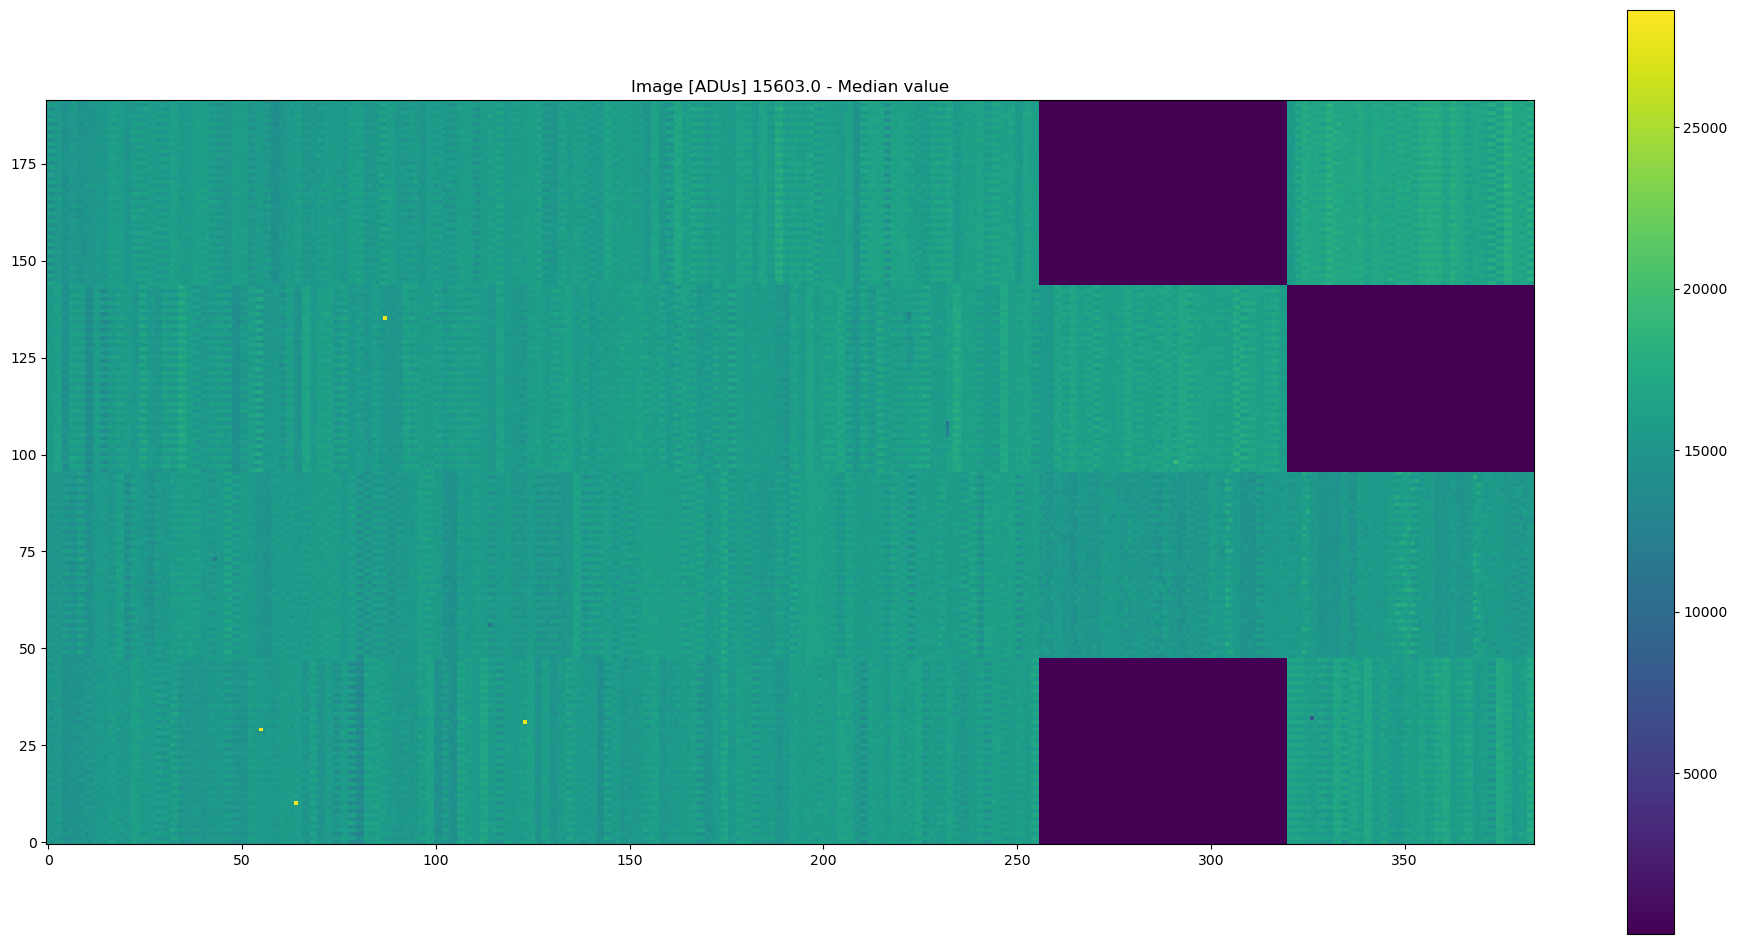

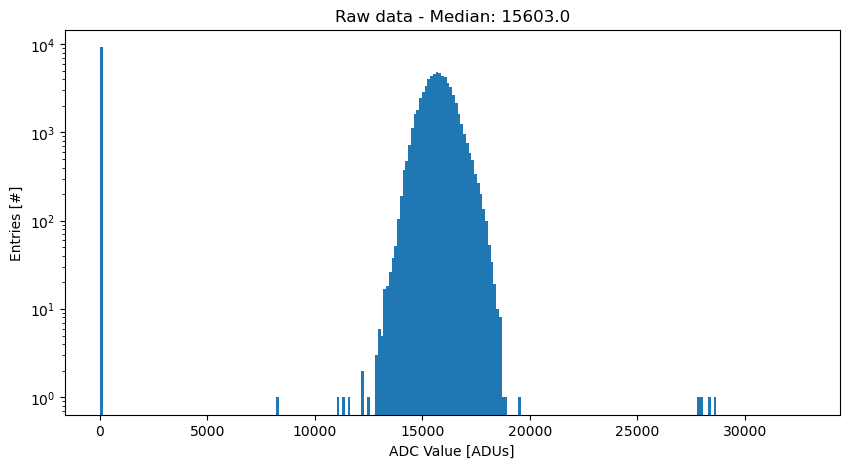

In [26]:
fig, ax = plt.subplots(figsize=(24, 12))

data = readoutFrames(dataDebug,100)

plt.imshow(data[:,:,0], origin='lower')
plt.title('Image [ADUs] {} - Median value'.format(np.median(data)))
plt.colorbar()

plt.figure(figsize = (10,5))
plt.hist(data[:,:,0].flatten(), range=[0,2**15],bins=2**8, log=True)
plt.title("Raw data - Median: {:}".format(getMedianDark(data)))
plt.ylabel("Entries [#]")
plt.xlabel("ADC Value [ADUs]")

# Automatic pipoclk_delay - Warning: not 100% reliable
Scans automatically all the pipoclk_delay settings, and does
1) Count how many pixels there are with noise above a threshold (per ADC row)

2) Plot images for each of the setting for visual inspection

pipoclk_delay value: 0
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 1
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 2
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 3
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 4
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 5
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 6
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 7
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 8
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 9
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 10
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 11
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 12
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 13
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 14
Data Descrambled
(192, 384, 100)
pipoclk_delay value: 15
Data Descrambled
(192, 384, 100)
[   0.    0.    0.    0.    0.    0.    0.    0. 5764.    0.    0.    0.
    0.    0.    0.    0.]

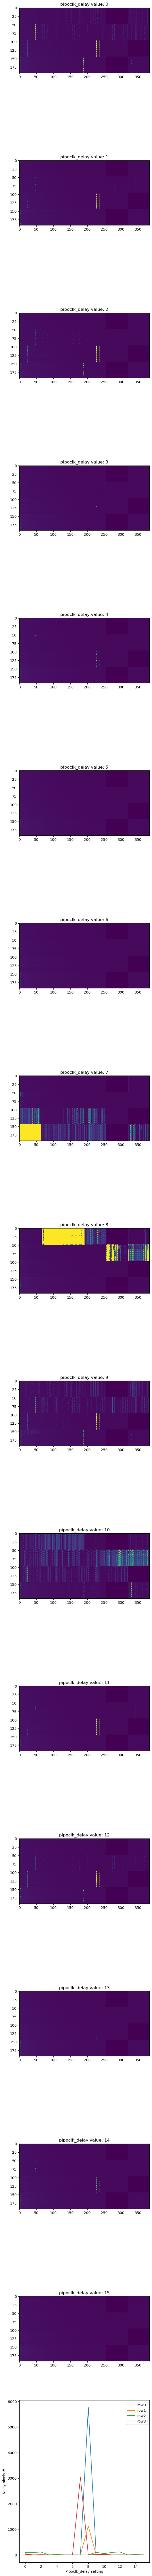

In [21]:
fig, ax = plt.subplots(17, 1, figsize=(6, 6*17))

# Create empty arrays
noisy_pixels_row0 = np.empty(16)
noisy_pixels_row1 = np.empty(16)
noisy_pixels_row2 = np.empty(16)
noisy_pixels_row3 = np.empty(16)

# Specify the noise threshold above which we treat the pixel as a pipoclk_dly glitch
noise_thr = 1000

delay_setting = 0

for i in range(16):
    print('pipoclk_delay value: {}'.format(i))
    ASIC.pipoclk_delay_row0.set(i)
    ASIC.pipoclk_delay_row1.set(i)
    ASIC.pipoclk_delay_row2.set(i)
    ASIC.pipoclk_delay_row3.set(i)
    
    # Get data and mask MSB (gain switching)
    data = readoutFrames(dataDebug,100)
    data = data & ~(1 << 16)

    # Try post-processing fix
    data[data == 0] = 16384
   
    noise_map = np.std(data, axis=2)
    
    noisy_pixels_row0[i] = sum(1 for j in (noise_map[48*0:48*1,:]).flatten() if j > noise_thr)
    noisy_pixels_row1[i] = sum(1 for j in (noise_map[48*1:48*2,:]).flatten() if j > noise_thr)
    noisy_pixels_row2[i] = sum(1 for j in (noise_map[48*2:48*3,:]).flatten() if j > noise_thr)
    noisy_pixels_row3[i] = sum(1 for j in (noise_map[48*3:48*4,:]).flatten() if j > noise_thr)
    
    ax[i].imshow(noise_map,vmax=1000)
    ax[i].set_title('pipoclk_delay value: {}'.format(i))
    
print(noisy_pixels_row0)


ax[16].plot(noisy_pixels_row0, label='row0')
ax[16].plot(noisy_pixels_row1, label='row1')
ax[16].plot(noisy_pixels_row2, label='row2')
ax[16].plot(noisy_pixels_row3, label='row3')

ax[16].set_ylabel('Noisy pixels #')
ax[16].set_xlabel('Pipoclk_delay setting')

plt.legend()
plt.tight_layout()



# Check that settings give good image
Try to automatically derive the best settings based on analysis done above

Setting pipoclk_dly_row0 to:  0
Setting pipoclk_dly_row1 to:  1
Setting pipoclk_dly_row2 to:  3
Setting pipoclk_dly_row3 to:  1
Fast DAC set to 0.937V
Data Descrambled
(192, 384, 100)


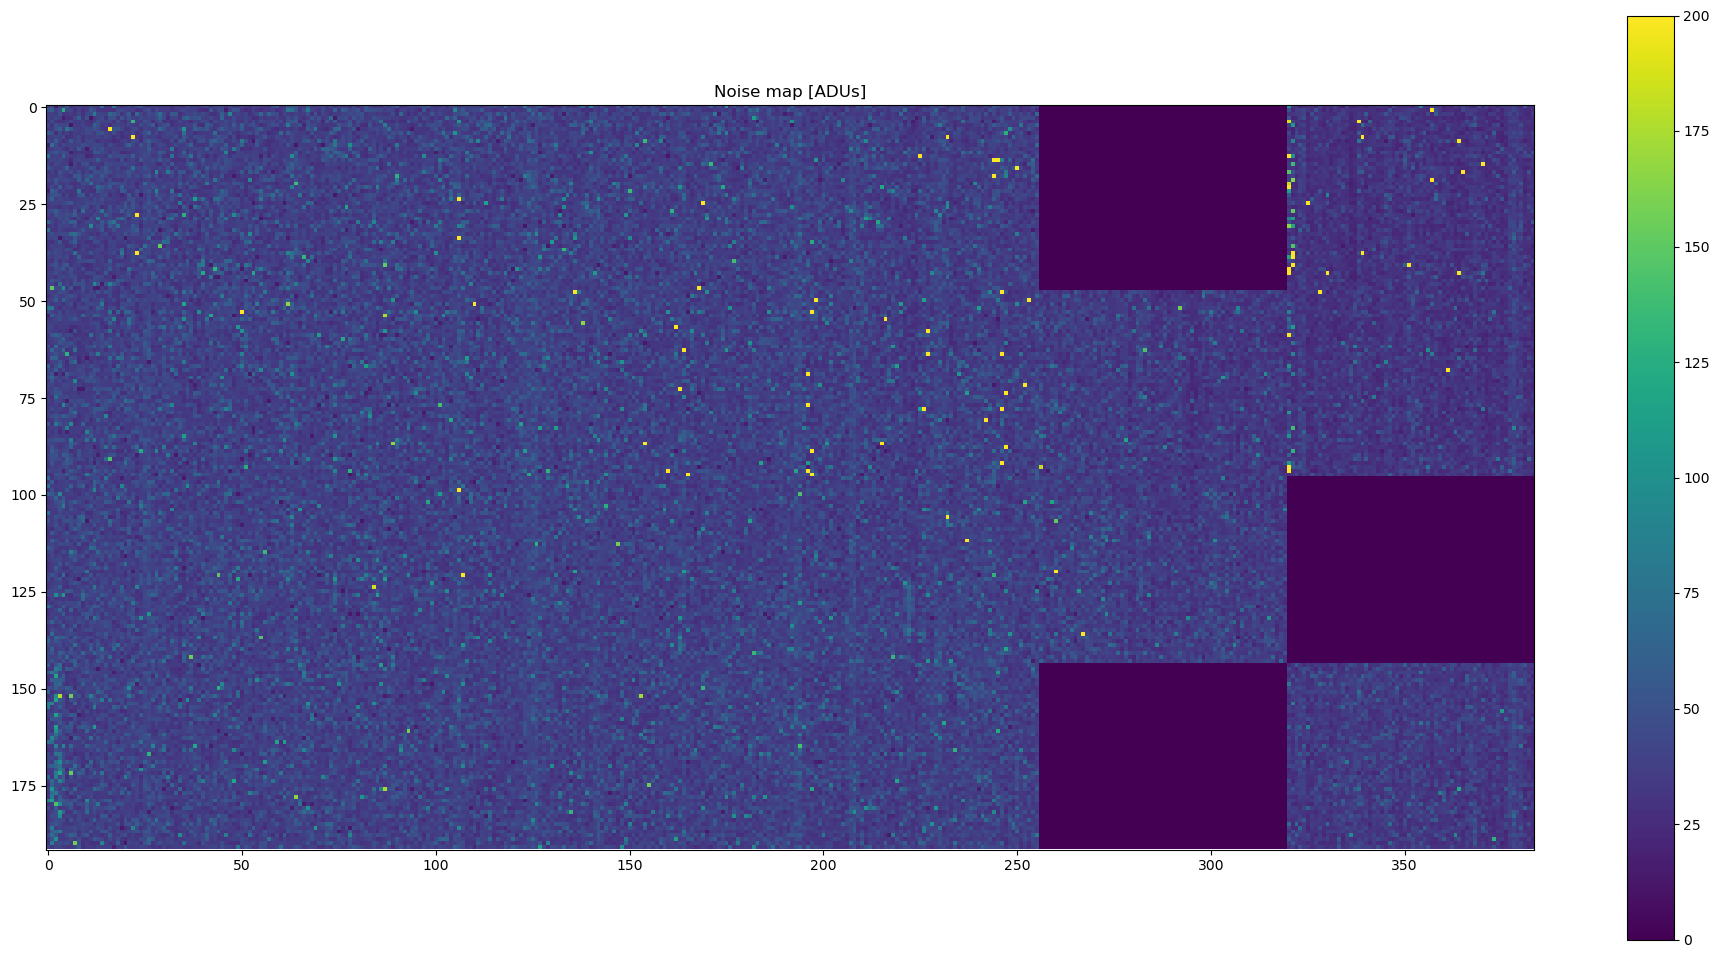

In [28]:
# Optimal delays are stored here
opt_row0 = noisy_pixels_row0.argmin()
opt_row1 = noisy_pixels_row1.argmin()
opt_row2 = noisy_pixels_row2.argmin()
opt_row3 = noisy_pixels_row3.argmin()

print('Setting pipoclk_dly_row0 to: ',opt_row0)
print('Setting pipoclk_dly_row1 to: ',opt_row1)
print('Setting pipoclk_dly_row2 to: ',opt_row2)
print('Setting pipoclk_dly_row3 to: ',opt_row3)

ASIC.pipoclk_delay_row0.set(int(opt_row0))
ASIC.pipoclk_delay_row1.set(int(opt_row1))
ASIC.pipoclk_delay_row2.set(int(opt_row2))
ASIC.pipoclk_delay_row3.set(int(opt_row3))

# For some reason, manual settings are better
ASIC.pipoclk_delay_row0.set(6)
ASIC.pipoclk_delay_row1.set(6)
ASIC.pipoclk_delay_row2.set(6)
ASIC.pipoclk_delay_row3.set(6)

time.sleep(0.1)

#write to DAC
DAC.FastDac.DacValue.set(0x5ff00)
print("Fast DAC set to {}V".format(DAC.FastDac.DacValueV.get()))

ASIC.mTest.set(False)      # Don't touch

data = readoutFrames(dataDebug,100)
data[data == 0] = 16384.0

fig, ax = plt.subplots(figsize=(24, 12))
plt.imshow(np.std(data, axis=2),vmax=200)
plt.title('Noise map [ADUs]')
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(figsize=(24, 12))
plt.imshow(data[:,:,6])
plt.title('Image [ADUs] {} - Median value'.format(np.median(data)))
plt.colorbar()

In [ ]:
#Plot histogram
data = data[50:180,:,:].astype(float)
data -= np.median(data, axis=2, keepdims=True)

fig, ax = plt.subplots(figsize=(24, 8))
ax.hist(data.flatten(), bins=200)

ax.set_xticks([0,-2**8,-2**9,-2**10,-2**11,-2**12,-2**13,-2**14])  # Set label locations.

ax.set_xlabel('Amplitude [ADUs]')
ax.set_ylabel('Entries [all pixels]')
ax.set_yscale('log')

# Show plot
plt.show()